# CNN LSTM for Time Series Forecasting using TF2

The goal is _multivariate, multistep, multivariate (output)_ time-series prediction/modelling using Bitcoin (BTC) data queried from the Internet with CNN-LSTM architecture.


[Reference](https://machinelearningmastery.com/cnn-long-short-term-memory-networks/)

[Multistep Time Series forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import LSTM, GRU, Input, Flatten, Dense, LSTM, RepeatVector
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, TimeDistributed, Dropout
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-08-14 22:33:37.980140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 22:33:37.997415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 22:33:37.997620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-14 22:33:37.998318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# Read in CSV file-
data = pd.read_csv("Datasets/BTC-USD.csv")

In [6]:
print(f"Dimensions of dataset: {data.shape}")

Dimensions of dataset: (1827, 7)


In [7]:
# Get data types for all features-
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
print(f"Are there any missing values in dataset? {data.isna().values.any()}")

Are there any missing values in dataset? False


In [9]:
# Convert 'Date' feature to datetime, sort in ascending order
# and reset resulting indices-
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by = 'Date', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [10]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,4073.260010,3159089920


In [11]:
print(f"min Date value = {data['Date'].min()} & max value = {data['Date'].max()}")

min Date value = 2017-08-09 00:00:00 & max value = 2022-08-09 00:00:00


In [12]:
# Get basic data statistics-
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,19416.397674,19921.360465,18849.730833,19424.722149,19424.722149,2.450380e+10
std,17376.407379,17823.080252,16853.925903,17367.955310,17367.955310,2.017131e+10
min,3166.300049,3275.377930,2946.620117,3154.949951,3154.949951,7.680150e+08
25%,7097.275635,7287.041260,6894.411133,7106.541992,7106.541992,7.367460e+09
50%,9936.162109,10191.675781,9694.650391,9951.518555,9951.518555,2.175686e+10
75%,33767.375000,34778.076172,32265.797851,33734.515625,33734.515625,3.440956e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [13]:
# Compute skew for numerical features:
for col in data.columns.tolist():
    if col == 'Date':
        continue
    else:
        print(f"{col} has {data[col].skew():.4f} skew")

Open has 1.0782 skew
High has 1.0694 skew
Low has 1.0886 skew
Close has 1.0772 skew
Adj Close has 1.0772 skew
Volume has 3.2190 skew


In [14]:
# Remove 'Adj Close' attribute-
data.drop(columns = ['Adj Close'], inplace = True)

In [15]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,3159089920


In [17]:
# Split into features and target-
X = data.drop(columns = ['Date', 'Open', 'Close'], axis = 1)
y = data[['Open', 'Close']].values

In [18]:
print(f"Features/predictors has shape: {X.shape} & target has"
      f" shape: {y.shape}")

Features/predictors has shape: (1827, 3) & target has shape: (1827, 2)


In [19]:
# Scale features and labels-
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler(feature_range = (0, 1))

X_scaled = std_scaler.fit_transform(X)
# y_scaled = mm_scaler.fit_transform(y.reshape(-1, 1))
y_scaled = mm_scaler.fit_transform(y)

In [20]:
X_scaled.shape, y.shape

((1827, 3), (1827, 2))

In [21]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(X_scaled[: int(len(X_scaled) * 0.9)]), len(X_scaled[int(len(X_scaled) * 0.9): ])

(1644, 183)

In [22]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(y_scaled[: int(len(X_scaled) * 0.9)]), len(y_scaled[int(len(X_scaled) * 0.9): ])

(1644, 183)

In [23]:
# Sanity check-
len(X_scaled[: int(len(X_scaled) * 0.9)]) + len(X_scaled[int(len(X_scaled) * 0.9): ]) == len(X_scaled)

True

In [24]:
X_train = X_scaled[: int(len(X_scaled) * 0.9)]
y_train = y_scaled[: int(len(X_scaled) * 0.9)]

In [25]:
X_test = X_scaled[int(len(X_scaled) * 0.9): ]
y_test = y_scaled[int(len(X_scaled) * 0.9): ]

In [26]:
# Sanity check-
X_train.shape, y_train.shape

((1644, 3), (1644, 2))

In [27]:
X_test.shape, y_test.shape

((183, 3), (183, 2))

In [28]:
def split_sequences(
    input_sequences, output_sequence,
    n_steps_in, n_steps_out
):
    '''
    Function to convert training data for Seq2Seq neural network
    '''
    X, y = list(), list()
    
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence-
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        
        # check if we are beyond the dataset-
        if out_end_ix > len(input_sequences):
            break
            
        # gather input and output of the pattern-
        # seq_x, seq_y = input_sequences[i : end_ix], output_sequence[end_ix - 1 : out_end_ix, -1]
        seq_x, seq_y = input_sequences[i : end_ix], output_sequence[end_ix - 1 : out_end_ix, :]
        
        X.append(seq_x), y.append(seq_y)
        
    return np.array(X), np.array(y)

In [29]:
# Define hyper-parameters for time-series forecasting-
look_back = 50
look_ahead = 10
num_features = 3

In [30]:
# Define hyper-parameters for training neural network-
batch_size = 256
num_epochs = 50

In [31]:
# Generate sequences required for Seq2Seq architecture-
X_train, y_train = split_sequences(
    input_sequences = X_train, output_sequence = y_train,
    n_steps_in = look_back, n_steps_out = look_ahead
)

X_test, y_test = split_sequences(
    input_sequences = X_test, output_sequence = y_test,
    n_steps_in = look_back, n_steps_out = look_ahead
)

In [32]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1586, 50, 3), y_train.shape: (1586, 10, 2)
X_test.shape: (125, 50, 3), y_test.shape: (125, 10, 2)


In [ ]:
# Create TF datasets-

# DO NOT USE 'shuffle()' since this is a time-series problem!
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

In [ ]:
# Sanity check-
# x, y = next(iter(train_dataset))
# x.shape, y.shape

### CNN-LSTM Encoder-Decoder architecture

- __A CNN, can be used as the encoder__ in an encoder-decoder architecture.

- __The CNN does not directly support sequence input; instead, a 1-D CNN is capable of reading across sequence input and automatically learning the salient features__. These can then be interpreted by an LSTM decoder as per normal.

- We refer to hybrid models that use a CNN and LSTM as [CNN-LSTM models](https://machinelearningmastery.com/cnn-long-short-term-memory-networks/), and in this case we are using them together in an encoder-decoder architecture.

- The CNN expects the input data to have the same 3D structure as the LSTM model, _although multiple features are read as different channels that ultimately have the same effect_.

- A CNN architecture for the encoder comprises of two convolutional layers followed by a max pooling layer, the results of which are then flattened.

- The first convolutional layer reads across the input sequence and projects the results onto feature maps.

- The second convolutional layer performs the same operation on the feature maps created by the first layer, attempting to amplify any salient features. We will use 64 feature maps per convolutional layer and __read the input sequences with a kernel size of three time steps__.

- The max pooling layer simplifies the feature maps by keeping 1/4 of the values with the largest (max) signal.

- __The distilled feature maps after the pooling layer are then flattened into one long vector that can then be used as input to the decoding process__.


In [49]:
# Define encoder-decoder model-
cnn_encoder_decoder_model = Sequential()

# Encoder-
cnn_encoder_decoder_model.add(
    Conv1D(
        filters = 64, kernel_size = 3,
        activation = tf.nn.relu,
        input_shape = (look_back, num_features)
    )
)
cnn_encoder_decoder_model.add(
    Conv1D(
        filters = 128, kernel_size = 3,
        activation = tf.nn.relu
    )
)
cnn_encoder_decoder_model.add(
    Conv1D(
        filters = 128, kernel_size = 3,
        activation = tf.nn.relu
    )
)
cnn_encoder_decoder_model.add(
    MaxPooling1D(pool_size = 2)
)
cnn_encoder_decoder_model.add(Flatten())

# Decoder-
cnn_encoder_decoder_model.add(RepeatVector(n = look_ahead))
cnn_encoder_decoder_model.add(
    LSTM(
        units = 128, activation = tf.keras.activations.tanh,
        return_sequences = True
    )
)
cnn_encoder_decoder_model.add(
    LSTM(
        units = 128, activation = tf.keras.activations.tanh,
        return_sequences = True
    )
)
cnn_encoder_decoder_model.add(
    LSTM(
        units = 128, activation = tf.keras.activations.tanh,
        return_sequences = True
    )
)
cnn_encoder_decoder_model.add(
    TimeDistributed(
        Dense(units = 128, activation = tf.nn.relu)
    )
)
cnn_encoder_decoder_model.add(
    TimeDistributed(Dense(units = 2))
)

In [50]:
# Get summary-
cnn_encoder_decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 48, 64)            640       
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 128)           24704     
                                                                 
 conv1d_4 (Conv1D)           (None, 44, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 22, 128)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2816)              0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 2816)         0         
 or)                                                  

In [51]:
# Count number of trainable parameters-
tot_params = 0

for layer in cnn_encoder_decoder_model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} non-zero params")

layer: (3, 3, 64) has 576 non-zero params
layer: (64,) has 0 non-zero params
layer: (3, 64, 128) has 24576 non-zero params
layer: (128,) has 0 non-zero params
layer: (3, 128, 128) has 49152 non-zero params
layer: (128,) has 0 non-zero params
layer: (2816, 512) has 1441792 non-zero params
layer: (128, 512) has 65536 non-zero params
layer: (512,) has 128 non-zero params
layer: (128, 512) has 65536 non-zero params
layer: (128, 512) has 65536 non-zero params
layer: (512,) has 128 non-zero params
layer: (128, 512) has 65536 non-zero params
layer: (128, 512) has 65536 non-zero params
layer: (512,) has 128 non-zero params
layer: (128, 128) has 16384 non-zero params
layer: (128,) has 0 non-zero params
layer: (128, 2) has 256 non-zero params
layer: (2,) has 0 non-zero params


In [52]:
print(f"CNN-LSTM encoder decoder model has {tot_params} trainable parameters")

CNN-LSTM encoder decoder model has 1860800 trainable parameters


In [53]:
# Compile defined model-
cnn_encoder_decoder_model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam()
)

In [36]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 10e-4,
    patience = 5,  restore_best_weights = True
)


In [54]:
# Train model-
train_history = cnn_encoder_decoder_model.fit(
    x = X_train, y = y_train,
    validation_data = (X_test, y_test),
    epochs = num_epochs, batch_size = batch_size,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
7/7 [==============================] - 3s 112ms/step - loss: 0.0547 - val_loss: 0.0568
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0161 - val_loss: 0.0675
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0102 - val_loss: 0.0649
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0078 - val_loss: 0.0284
Epoch 5/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0230
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0219
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0200
Epoch 8/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0203
Epoch 9/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0296
Epoch 10/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0229
Epoch 11/50
7/7 [===========

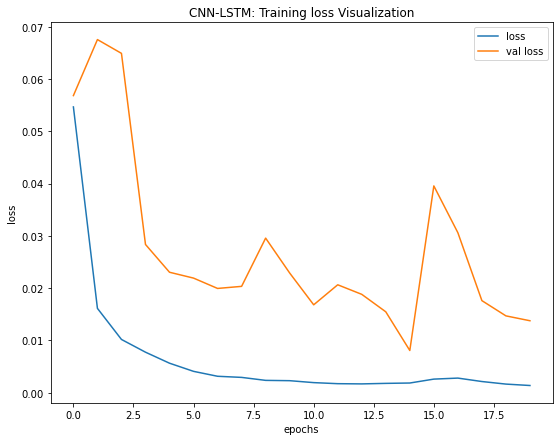

In [55]:
# Visualize training-
plt.figure(figsize = (9, 7))
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("CNN-LSTM: Training loss Visualization")
plt.show()

In [56]:
# Save trained model-
cnn_encoder_decoder_model.save_weights("CNN_LSTM_BTC_Prediction-Trained_Parameters.h5", overwrite = True)

In [57]:
# Make predictions using trained model-
predictions = cnn_encoder_decoder_model(X_test)

In [58]:
# Sanity check-
y_test.shape, predictions.shape

((125, 10, 2), TensorShape([125, 10, 2]))

In [59]:
# Define two lists to contain true vs. predicted values-
true_vals = []
pred_vals = []

In [60]:
for i in range(y_test.shape[0]):
    true_vals.append(y_test[i, 0, :])

In [61]:
for i in range(len(predictions)):
    pred_vals.append(predictions[i, 0, :])

In [62]:
# Convert to numpy arrays-
true_vals = np.asarray(true_vals)
pred_vals = np.asarray(pred_vals)

In [63]:
# Sanity check-
true_vals.shape, pred_vals.shape

((125, 2), (125, 2))

### Visualize true vs. predicted values ∀ attributes

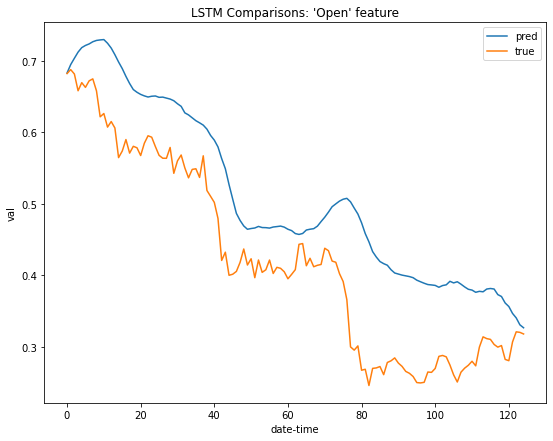

In [64]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 0].flatten(), label = 'pred')
plt.plot(true_vals[:, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Open' feature")
plt.legend(loc = 'best')
plt.show()

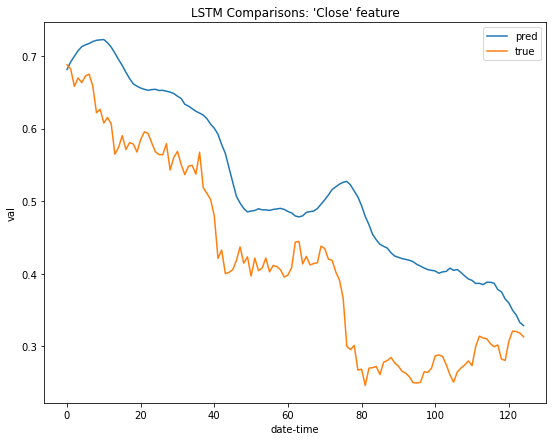

In [65]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 1].flatten(), label = 'pred')
plt.plot(true_vals[:, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Close' feature")
plt.legend(loc = 'best')
plt.show()

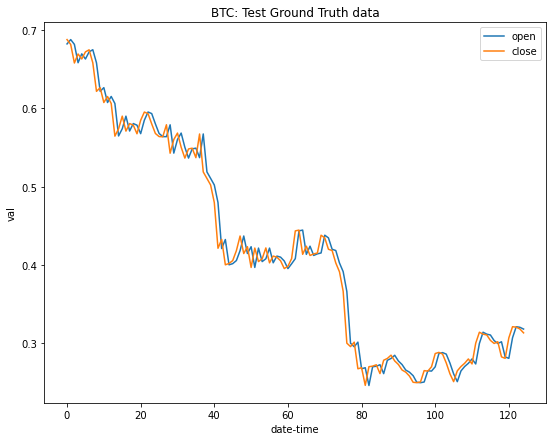

In [66]:
plt.figure(figsize = (9, 7))
plt.plot(true_vals[:, 0].flatten(), label = 'open')
plt.plot(true_vals[:, 1].flatten(), label = 'close')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("BTC: Test Ground Truth data")
plt.legend(loc = 'best')
plt.show()